In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
balanced_train_dir = os.path.join(dataset_dir, 'balanced_train') # We're using the balanced dataset
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
#Set the parameter used to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

#Creation of the training, validation and test set

We exploit the directory hierarchy of our dataset to infer the classes from the
name of the directories, more details are present in the report about the choices taken.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed=1024)

validation_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed=1024)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 8100 files belonging to 18 classes.
Using 7290 files for training.
Found 8100 files belonging to 18 classes.
Using 810 files for validation.
Found 1112 files belonging to 18 classes.


#BUILDING THE NETWORK

Let's add a droput layer with a droput rate between 0.2 and 0.5.

To see the choices taken see the report.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers


classes = list(os.listdir(balanced_train_dir))

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, strides=1 , activation="relu", padding="valid")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu", padding="valid")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu", padding="valid")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", padding="valid")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", padding="valid")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(18, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

#Train the network

In the following cell the training procedure is started, we've passed the 
training set, the number of epochs, the validation split. 

In [ ]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset
                    )

Epoch 1/50
114/114 [==============================] - 35s 275ms/step - loss: 2.5398 - accuracy: 0.1894 - val_loss: 2.2407 - val_accuracy: 0.2988
Epoch 2/50
114/114 [==============================] - 33s 271ms/step - loss: 2.1590 - accuracy: 0.3097 - val_loss: 2.0888 - val_accuracy: 0.3235
Epoch 3/50
114/114 [==============================] - 32s 269ms/step - loss: 1.9685 - accuracy: 0.3791 - val_loss: 1.8796 - val_accuracy: 0.3963
Epoch 4/50
114/114 [==============================] - 34s 287ms/step - loss: 1.8059 - accuracy: 0.4325 - val_loss: 1.8264 - val_accuracy: 0.4111
Epoch 5/50
114/114 [==============================] - 32s 269ms/step - loss: 1.6749 - accuracy: 0.4693 - val_loss: 1.7233 - val_accuracy: 0.4753
Epoch 6/50
114/114 [==============================] - 32s 269ms/step - loss: 1.5500 - accuracy: 0.5060 - val_loss: 1.5882 - val_accuracy: 0.4963
Epoch 7/50
114/114 [==============================] - 33s 268ms/step - loss: 1.4099 - accuracy: 0.5527 - val_loss: 1.5334 - val_ac

In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'model_balanced_training_set_droput.h5'))

**Results of the training phase**

In the following cell we've obtained the plots of the accuracy and loss for both
the training and validation set.

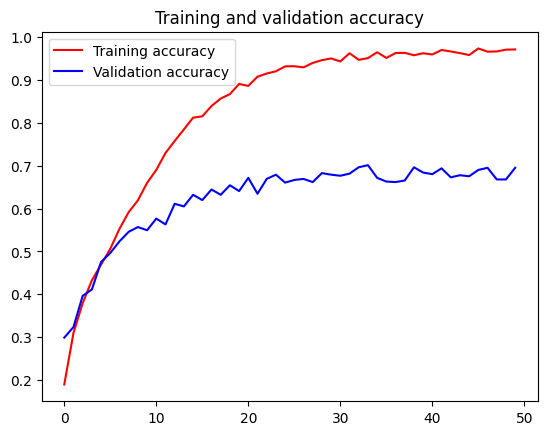

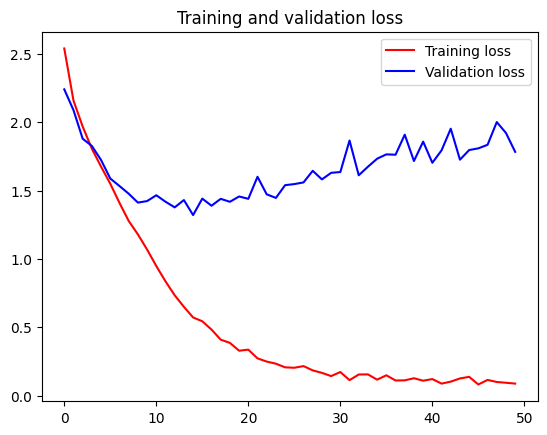

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluation of the model
In the following cells we've evaluated the model exploting the test set, obtaining its loss and accuracy.

In [ ]:
#Evaluate the model on the training set
test_loss, test_acc = model.evaluate(test_dataset)

#Save the rusults in the history dictionary
history.history["test_loss"] = test_loss
history.history["test_accuracy"] = test_acc

print('test_acc:', test_acc)
print('test_loss:', test_loss)

18/18 [==============================] - 8s 286ms/step - loss: 3.4581 - accuracy: 0.5171
test_acc: 0.5170863270759583
test_loss: 3.4581141471862793


Save the model and its history in the models' folder

In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'model2_adding_droput_05.h5'))
with open(os.path.join(dir_name, 'model2history0.5'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
from tensorflow.keras import backend as K
del history
print('model deleted')
K.clear_session()